In [3]:
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
from rdkit.Chem import Draw
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from math import pi



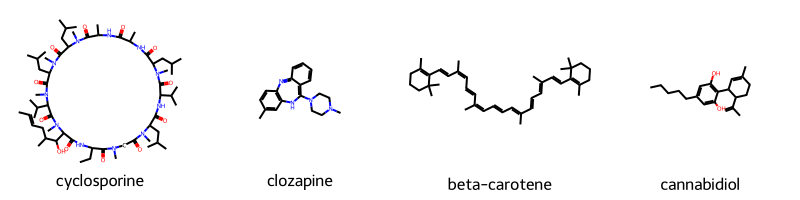

In [4]:
smiles_1 = 'CCC1C(=O)N(CC(=O)N(C(C(=O)NC(C(=O)N(C(C(=O)NC(C(=O)NC(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N(C(C(=O)N1)C(C(C)CC=CC)O)C)C(C)C)C)CC(C)C)C)CC(C)C)C)C)C)CC(C)C)C)C(C)C)CC(C)C)C)C' # Cyclosporine
smiles_2 = 'CN1CCN(CC1)C2=C3C=CC=CC3=NC4=C(N2)C=C(C=C4)C' # Clozapine
smiles_3 = 'CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC=CC=C(C)C=CC=C(C)C=CC2=C(CCCC2(C)C)C)C)C' # Beta-carotene
smiles_4 = 'CCCCCC1=CC(=C(C(=C1)O)C2C=C(CCC2C(=C)C)C)O' # Cannabidiol
smiles_list = [smiles_1, smiles_2, smiles_3, smiles_4]
names_list = ['cyclosporine', 'clozapine', 'beta-carotene', 'cannabidiol']
mol_list = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

Draw.MolsToGridImage(mol_list, legends=names_list, molsPerRow=4)


Calculate rule of five molecular properties and plot them

The chemical properties relevant for the rule of five are calculated and visually compared:

    Calculate molecular weight, number of h-bond acceptors and donors, and logP.
    Using the predefined functions in the rdkit descriptor library



In [5]:


MWs = [Descriptors.ExactMolWt(mol) for mol in mol_list]
HBAs = [Descriptors.NumHAcceptors(mol) for mol in mol_list]
HBDs = [Descriptors.NumHDonors(mol) for mol in mol_list]
LogPs = [Descriptors.MolLogP(mol) for mol in mol_list]
parameters = [MWs, HBAs, HBDs, LogPs]
print('Molecular weight of the four compounds:',MWs)



Molecular weight of the four compounds: [1201.841367992, 306.184446704, 536.438201792, 314.2245802]


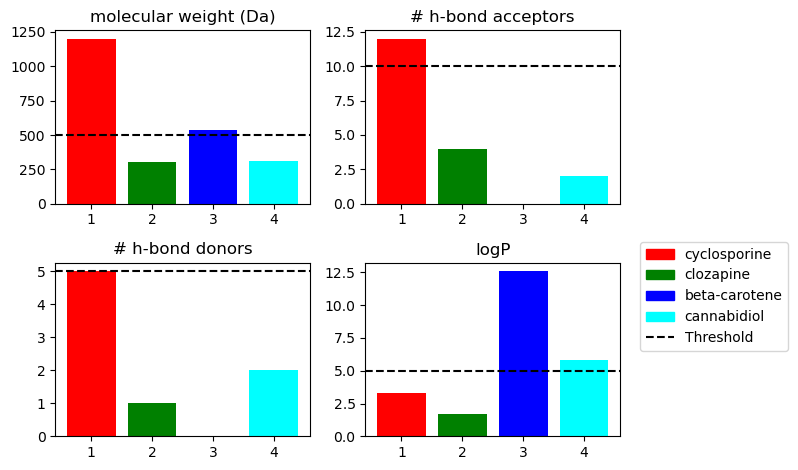

In [6]:
# Start 2x2 plot frame
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
axes = [ax1, ax2, ax3, ax4]
x = np.arange(1, len(mol_list)+1)
colors = ['red', 'green', 'blue', 'cyan']

# Create subplots
for index in x-1:
    axes[index].bar(x, parameters[index], color=colors)

# Add rule of five thresholds as dashed lines
ax1.axhline(y=500, color="black", linestyle="dashed")
ax1.set_title("molecular weight (Da)")
ax2.axhline(y=10, color="black", linestyle="dashed")
ax2.set_title("# h-bond acceptors")
ax3.axhline(y=5, color="black", linestyle="dashed")
ax3.set_title("# h-bond donors")
ax4.axhline(y=5, color="black", linestyle="dashed")
ax4.set_title("logP")

# Add legend
legend_elements = [mpatches.Patch(color=colors[i], label=names_list[i]) for i in range(len(mol_list))]
legend_elements.append(Line2D([0], [0], color="black", ls="dashed", label="Threshold"))
fig.legend(handles=legend_elements, bbox_to_anchor=(1.25, 0.5))

# Fit subplots and legend into figure
plt.tight_layout()

plt.show()


### Investigate compliance with Lipinski's rule of five

A function is defined to investigate whether a compound violates the rule of five and is applied to our example compounds.


In [7]:
def test_rule_of_five(smi):
    m = Chem.MolFromSmiles(smi)
    
    # Calculate rule of five chemical properties
    MW = Descriptors.ExactMolWt(m)
    HBA = Descriptors.NumHAcceptors(m)
    HBD = Descriptors.NumHDonors(m)
    LogP = Descriptors.MolLogP(m)
    
    # Rule of five conditions
    conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
    # Return True if no more than one out of four conditions is violated
    return conditions.count(True) >= 3



for i in range(len(smiles_list)):
    smi=smiles_list[i]
    name=names_list[i]
    print("Rule of five accepted for %s: %s "%(name,test_rule_of_five(smi)))                



Rule of five accepted for cyclosporine: False 
Rule of five accepted for clozapine: True 
Rule of five accepted for beta-carotene: False 
Rule of five accepted for cannabidiol: True 



### Apply rule of five to the EGFR dataset

The test_rule_of_five function can be used to filter the main dataset by compliance with Lipinski's rule of five.

    Adjust the function to return all chemical parameters related to the rule of five
    Load main dataframe (ChEMBL_df)
    Apply rule of five function to ChEMBL_df
    Filter ChEMBL_df by compounds that violate more than one rule
    Save filtered dataframe



In [ ]:
def df_rule_of_five(df):
    
    smi = df['smiles']
    m = Chem.MolFromSmiles(smi)
    
    # Calculate rule of five chemical properties
    MW = Descriptors.ExactMolWt(m)
    HBA = Descriptors.NumHAcceptors(m)
    HBD = Descriptors.NumHDonors(m)
    LogP = Descriptors.MolLogP(m)
    
    # Rule of five conditions
    conditions = [MW <= 500, HBA <= 10, HBD <= 5, LogP <= 5]
    
    # Create pandas row for conditions results with values and information whether rule of five is violated
    return pd.Series([MW, HBA, HBD, LogP, 'yes']) if conditions.count(True) >= 3 else pd.Series([MW, HBA, HBD, LogP, 'no'])

In [ ]:
ChEMBL_df = pd.read_csv('../data/T1/EGFR_compounds.csv', index_col=0)
# Apply ruleOfFive to dataset to get rule of five results (may take a while)
rule5_prop_df = ChEMBL_df.apply(df_rule_of_five, axis=1)

# Name condition columns
rule5_prop_df.columns= ['MW', 'HBA', 'HBD', 'LogP', 'rule_of_five_conform']
# Concatenate dataset with computed values
ChEMBL_df = ChEMBL_df.join(rule5_prop_df)

### MCS
The maximum common structure (MCS) is defined as the largest substructure that appears in two or more candidate molecules.

    Finding the MCS = maximum common subgraph isomorphism problem
    Has many applications in the field of cheminformatics: similarity search, hierarchical clustering, or molecule alignment

    Details on MCS algorithms (see review: J Comput Aided Mol Des. 2002 Jul; 16(7):521-33)

    Determining an MCS between two or more graphs is an NP-complete problem
    Algorithms for exact determination as well as approximations exist
        Exact: Maximum-clique, backtracking, dynamic programming
        Approximate: Genetic algorithm, combinatorial optimization, fragment storage, ...
        Problem reduction: Simplify the molecular graphs

Example of an implementation: FMCS algorithm

    Models MCS problem as a graph isomorphism problem
    Based on subgraph enumeration and subgraph isomorphism testing


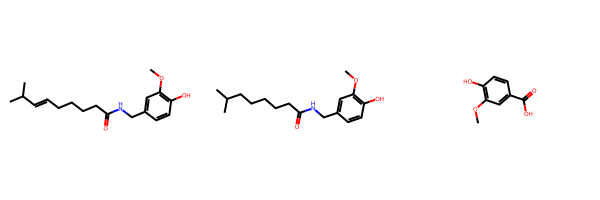

In [ ]:
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import MCS

smis = ("O=C(NCc1cc(OC)c(O)cc1)CCCC/C=C/C(C)C", "CC(C)CCCCCC(=O)NCC1=CC(=C(C=C1)O)OC", "c1(C(=O)O)cc(OC)c(O)cc1")
mols = [Chem.MolFromSmiles(x) for x in smis]
     
Draw.MolsToGridImage(mols)


C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_26408\2070405628.py:1: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  mcs=MCS.FindMCS(mols)


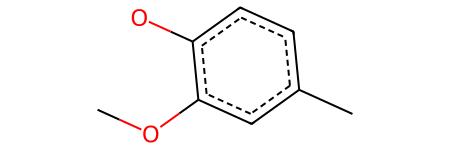

In [12]:
mcs=MCS.FindMCS(mols)
Chem.MolFromSmarts(mcs.smarts)

In [13]:
supplier = Chem.ForwardSDMolSupplier('data/molecule_set.sdf')
mols = list(supplier)

print(f"Set with {len(mols)} molecules loaded.")

Set with 145 molecules loaded.


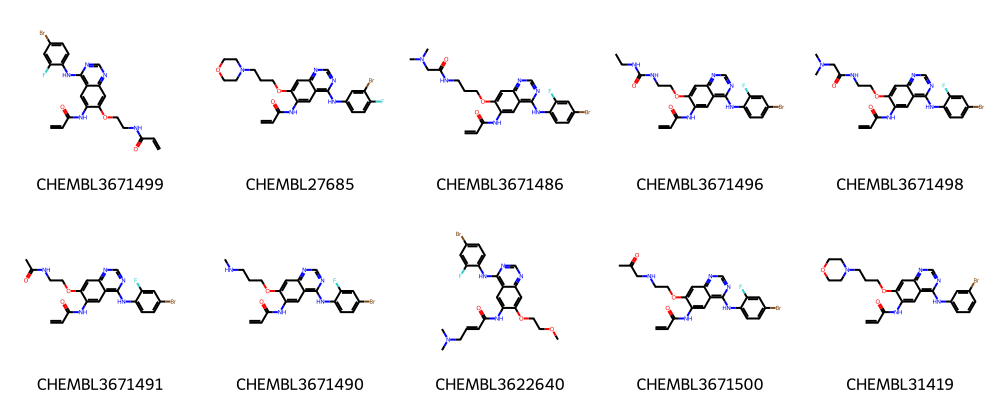

In [14]:
## Show only first 10 molecules -- use slicing
num_mols = 10
legends = [mol.GetProp("_Name") for mol in mols]
Draw.MolsToGridImage(mols[:num_mols], legends=legends[:num_mols], molsPerRow=5)

Run the FMCS algorithm with different input parameters
The FMCS algorithm is implemented in RDKit: rdFMCS


MCS1 contains 24 atoms and 26 bonds.
MCS SMARTS string: [#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]


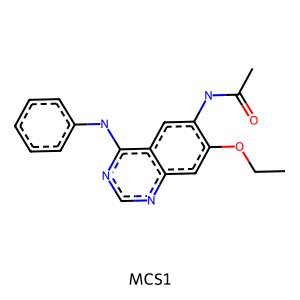

In [15]:
from rdkit import Chem, Geometry
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from rdkit.Chem import PandasTools

mcs1 = rdFMCS.FindMCS(mols)
print(f"MCS1 contains {mcs1.numAtoms} atoms and {mcs1.numBonds} bonds.")
print("MCS SMARTS string:", mcs1.smartsString)


# Draw substructure from Smarts
m1 = Chem.MolFromSmarts(mcs1.smartsString)
Draw.MolToImage(m1, legend="MCS1")




#### Set a threshold

It is possible to lower the threshold for the substructure, for example so that the MCS only has to occur in e.g. 80% of the input structures.


In [18]:
mcs2 = rdFMCS.FindMCS(mols, threshold=0.8)
print(f"MCS2 contains {mcs2.numAtoms} atoms and {mcs2.numBonds} bonds.")
print("SMARTS string:", mcs2.smartsString)

MCS2 contains 28 atoms and 30 bonds.
SMARTS string: [#6]=[#6]-[#6](=[#8])-[#7]-[#6]1:[#6]:[#6]2:[#6](-[#7]-[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3-[#9]):[#7]:[#6]:[#7]:[#6]:2:[#6]:[#6]:1-[#8]-[#6]-[#6]-[#7]-[#6]


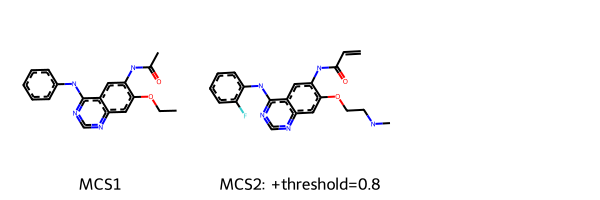

In [19]:
# Draw substructure
m2 = Chem.MolFromSmarts(mcs2.smartsString)
Draw.MolsToGridImage([m1, m2], legends=["MCS1", "MCS2: +threshold=0.8"])

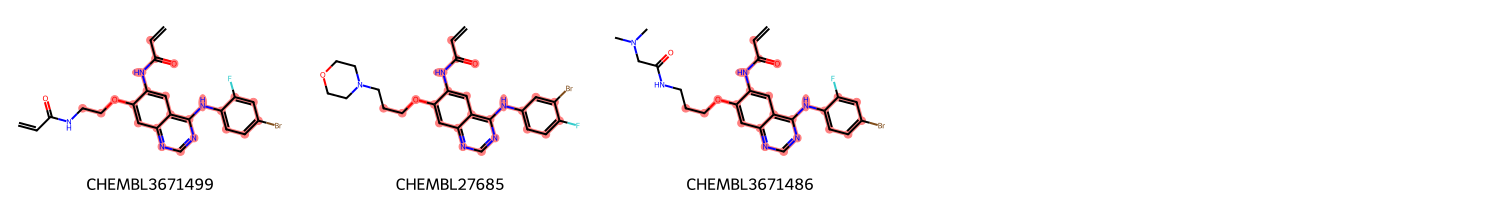

In [17]:
from copy import deepcopy
import random

def highlight_molecules(molecules, mcs, number, label=True, same_orientation=True, **kwargs):
    """Highlight the MCS in our query molecules"""
    molecules = deepcopy(molecules)
    # convert MCS to molecule
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    # find the matching atoms in each molecule
    matching = [molecule.GetSubstructMatch(pattern) for molecule in molecules[:number]]

    legends = None
    if label is True:
        legends = [x.GetProp("_Name") for x in molecules]

    # Align by matched substructure so they are depicted in the same orientation
    # Adapted from: https://gist.github.com/greglandrum/82d9a86acb3b00d3bb1df502779a5810
    if same_orientation:
        mol, match = molecules[0], matching[0]
        AllChem.Compute2DCoords(mol)
        coords = [mol.GetConformer().GetAtomPosition(x) for x in match]
        coords2D = [Geometry.Point2D(pt.x, pt.y) for pt in coords]
        for mol, match in zip(molecules[1:number], matching[1:number]):
            if not match:
                continue
            coord_dict = {match[i]: coord for i, coord in enumerate(coords2D)}
            AllChem.Compute2DCoords(mol, coordMap=coord_dict)

    return Draw.MolsToGridImage(
        molecules[:number],
        legends=legends,
        molsPerRow=5,
        highlightAtomLists=matching[:number],
        subImgSize=(300, 200),
        **kwargs,
    )

img = highlight_molecules(mols, mcs1, 3, useSVG=True)
img

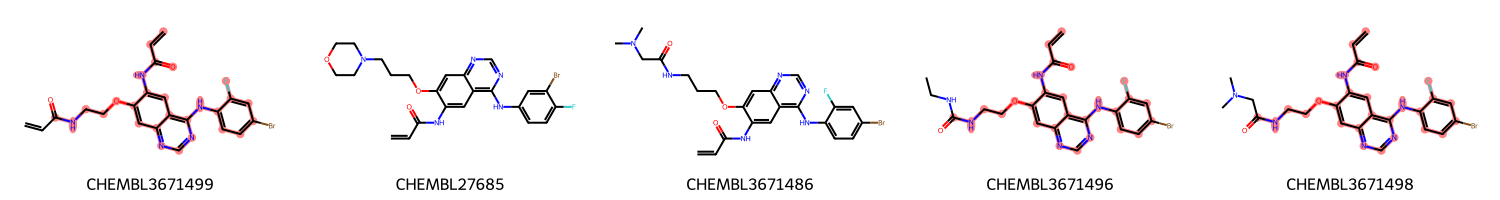

In [20]:
highlight_molecules(mols, mcs2, 5)


#### Match ring bonds

In the above example it may not be obvious, but by default ring bonds can match non-ring bonds. Often from an application point of view, we want to retain rings. Thus, one can set the ringMatchesRingOnly parameter to True, then only ring bonds match with other ring bonds.


MCS3 contains 28 atoms and 30 bonds.
SMARTS string: [#6&!R]=&!@[#6&!R]-&!@[#6&!R](=&!@[#8&!R])-&!@[#7&!R]-&!@[#6]1:&@[#6]:&@[#6]2:&@[#6](-&!@[#7&!R]-&!@[#6]3:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@[#6]:&@3-&!@[#9&!R]):&@[#7]:&@[#6]:&@[#7]:&@[#6]:&@2:&@[#6]:&@[#6]:&@1-&!@[#8&!R]-&!@[#6&!R]-&!@[#6&!R]-&!@[#7&!R]-&!@[#6&!R]


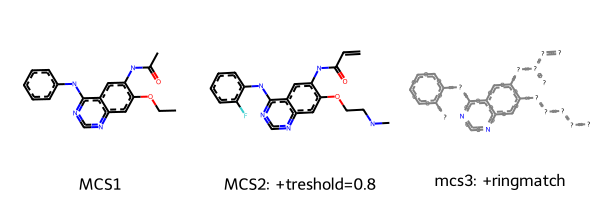

In [21]:
mcs3 = rdFMCS.FindMCS(mols, threshold=0.8, ringMatchesRingOnly=True)
print(f"MCS3 contains {mcs3.numAtoms} atoms and {mcs3.numBonds} bonds.")
print("SMARTS string:", mcs3.smartsString)

# Draw substructure
m3 = Chem.MolFromSmarts(mcs3.smartsString)
Draw.MolsToGridImage([m1, m2, m3], legends=["MCS1", "MCS2: +treshold=0.8", "mcs3: +ringmatch"])

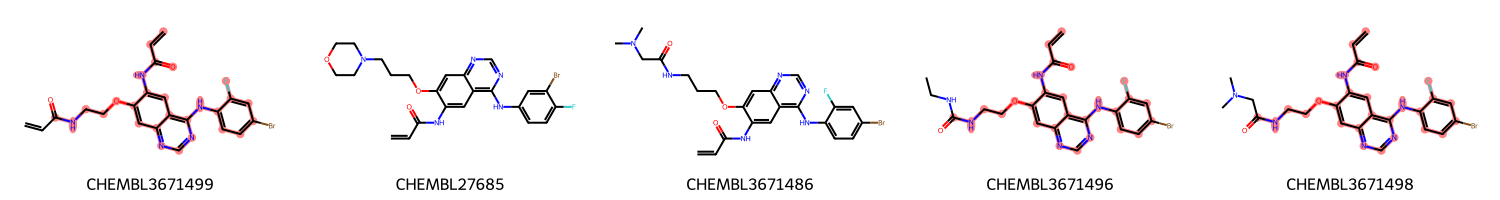

In [22]:
highlight_molecules(mols, mcs3, 5)

We will use rdkit to encode molecules (molecular fingerprints) and compare them in order to calculate their similarity (molecular similarity measures), as discussed in the theory section above.

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
)

,smiles,name,ROMol
0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,
1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,
2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,

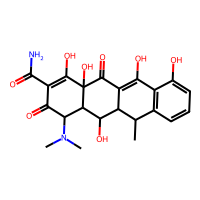
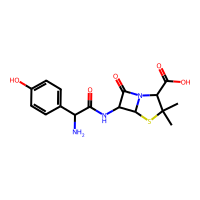
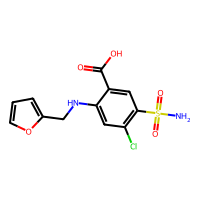

In [24]:
# Molecules in SMILES format
molecule_smiles = [
    "CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C(=O)O)C",
    "C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl",
    "CCCCCCCCCCCC(=O)OCCOC(=O)CCCCCCCCCCC",
    "C1NC2=CC(=C(C=C2S(=O)(=O)N1)S(=O)(=O)N)Cl",
    "CC1=C(C(CCC1)(C)C)C=CC(=CC=CC(=CC(=O)O)C)C",
    "CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4O)O)O)O)C(=O)N)N(C)C)O",
    "CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O",
]

# List of molecule names
molecule_names = [
    "Doxycycline",
    "Amoxicilline",
    "Furosemide",
    "Glycol dilaurate",
    "Hydrochlorothiazide",
    "Isotretinoin",
    "Tetracycline",
    "Hemi-cycline D",
]

molecules = pd.DataFrame({"smiles": molecule_smiles, "name": molecule_names})
PandasTools.AddMoleculeColumnToFrame(molecules, smilesCol="smiles")
PandasTools.RenderImagesInAllDataFrames(True)
molecules.head(3)

In [ ]:
## For one molecule
molecule = molecules["ROMol"][0]
maccs_fp = MACCSkeys.GenMACCSKeys(molecule)
#NBVAL_CHECK_OUTPUT
maccs_fp.ToBitString()

'00000000000000000000000000100000000000000000000000100110000000000010000010101000000011100100110101010100010000101100010000100001000101001001111111101111101011111111110'

In [30]:
## Applied to all molecules: Add MACCS fingerprints for all molecules to the DataFrame.
molecules["maccs"] = molecules.ROMol.apply(MACCSkeys.GenMACCSKeys)


##2D molecular descriptors: Morgan fingerprint

We can also calculate the circular Morgan fingerprints with rdkit. The Morgan fingerprint can be calculated either as int or bit vector. We specify a radius of 2 and a vector of length 2048.

In [ ]:
fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048) ## Fpsize can ve 4096 
circular_int_fp = fpg.GetCountFingerprint(molecule)
print(f"Print non-zero elements:\n{circular_int_fp.GetNonzeroElements()}")

Print non-zero elements:
{45: 1, 118: 1, 140: 1, 163: 1, 276: 1, 303: 1, 309: 1, 314: 2, 371: 1, 438: 1, 525: 1, 557: 1, 650: 3, 673: 1, 699: 1, 807: 6, 824: 1, 829: 1, 881: 1, 1009: 1, 1019: 5, 1027: 1, 1039: 1, 1057: 3, 1060: 1, 1061: 1, 1070: 1, 1082: 1, 1088: 1, 1119: 1, 1154: 1, 1163: 2, 1171: 1, 1257: 1, 1296: 1, 1309: 1, 1341: 1, 1380: 9, 1389: 1, 1457: 1, 1471: 1, 1487: 1, 1582: 1, 1602: 3, 1607: 1, 1630: 1, 1747: 1, 1750: 2, 1831: 1, 1833: 1, 1857: 1, 1873: 3, 1917: 1, 1932: 1, 2000: 1, 2029: 1}


In [32]:
molecules["morgan"] = molecules["ROMol"].map(fpg.GetFingerprint)


#### Calculate molecular similarity

In the following, we will apply two similarity measures, i.e. Tanimoto and Dice, to our two fingerprint types, i.e. MACCS and Morgan fingerprints.

Example molecule pair: Compare two MACCS fingerprints with the Tanimoto similarity.


In [34]:
# Example molecules
molecule1 = molecules["ROMol"][0]
molecule2 = molecules["ROMol"][1]

# Example fingerprints
maccs_fp1 = MACCSkeys.GenMACCSKeys(molecule1)
maccs_fp2 = MACCSkeys.GenMACCSKeys(molecule2)

print("Different Molecule:",DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp2))

print("Same Molecule:",DataStructs.TanimotoSimilarity(maccs_fp1, maccs_fp1))

Different Molecule: 0.5909090909090909
Same Molecule: 1.0




In the following, we want to compare a query molecule with our molecule list. Therefore, we use BulkTanimotoSimilarity and BulkDiceSimilarity from rdkit that calculate the similarity of a query fingerprint with a list of fingerprints, based on a similarity measure. We will investigate all combinations of MACCS/Morgan fingerprint comparisons based on the Tanimoto/Dice similarity measure.
#### MACCS fingerprints: Tanimoto similarity and Dice similarity

Add the Tanimoto and Dice similarities between MACCS fingerprints to the DataFrame.


In [35]:
molecule_query = molecules["maccs"][0]
molecule_list = molecules["maccs"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_maccs"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

preview = molecules.sort_values(["tanimoto_maccs"], ascending=False).reset_index()
preview[["name", "tanimoto_maccs", "dice_maccs"]]

,name,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000
1,Tetracycline,0.928571,0.962963
2,Amoxicilline,0.590909,0.742857
3,Hemi-cycline D,0.403509,0.575000
4,Furosemide,0.321839,0.486957
5,Hydrochlorothiazide,0.306818,0.469565
6,Isotretinoin,0.288136,0.447368
7,Glycol dilaurate,0.149254,0.259740



Morgan fingerprints: Tanimoto similarity and Dice similarity

Add the Tanimoto and Dice similarities between the Morgan fingerprints to the DataFrame.


In [36]:
# Define molecule query and list
molecule_query = molecules["morgan"][0]
molecule_list = molecules["morgan"].to_list()
# Calculate similarty values between query and list elements
molecules["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
molecules["dice_morgan"] = DataStructs.BulkDiceSimilarity(molecule_query, molecule_list)

preview = molecules.sort_values(["tanimoto_morgan"], ascending=False).reset_index()
preview[["name", "tanimoto_morgan", "dice_morgan", "tanimoto_maccs", "dice_maccs"]]

,name,tanimoto_morgan,dice_morgan,tanimoto_maccs,dice_maccs
0,Doxycycline,1.000000,1.000000,1.000000,1.000000
1,Tetracycline,0.534247,0.696429,0.928571,0.962963
2,Hemi-cycline D,0.308824,0.471910,0.403509,0.575000
3,Amoxicilline,0.144444,0.252427,0.590909,0.742857
4,Furosemide,0.098901,0.180000,0.321839,0.486957
5,Isotretinoin,0.067416,0.126316,0.288136,0.447368
6,Hydrochlorothiazide,0.058824,0.111111,0.306818,0.469565
7,Glycol dilaurate,0.054795,0.103896,0.149254,0.259740


In [43]:
molecule_query

,index,smiles,name,ROMol,maccs,morgan,tanimoto_maccs,dice_maccs,tanimoto_morgan,dice_morgan
0,0,CC1C2C(C3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Doxycycline,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000,1.000000,1.000000,1.000000
1,6,CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C1C=CC=C4...,Tetracycline,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.928571,0.962963,0.534247,0.696429
2,7,CC1C(CC(=O)C2=C1C=CC=C2O)C(=O)O,Hemi-cycline D,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.403509,0.575000,0.308824,0.471910
3,1,CC1(C(N2C(S1)C(C2=O)NC(=O)C(C3=CC=C(C=C3)O)N)C...,Amoxicilline,,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.590909,0.742857,0.144444,0.252427
4,2,C1=COC(=C1)CNC2=CC(=C(C=C2C(=O)O)S(=O)(=O)N)Cl,Furosemide,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.321839,0.486957,0.098901,0.180000

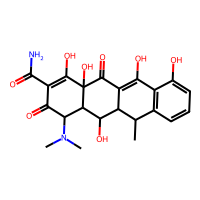
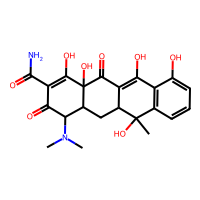
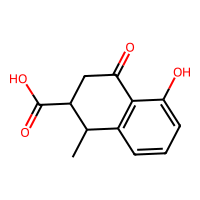
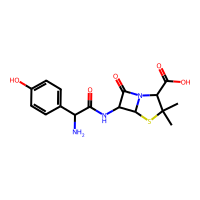
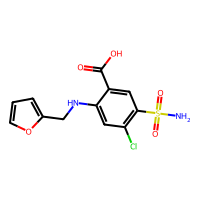

In [38]:
preview.head(5)

#### Virtual screening using similarity search

Now that we have learned how to calculate fingerprints and the similarity between them, we can apply this knowledge to a similarity search of a query molecule against a full data set of molecules.

In [50]:
molecule_dataset = pd.read_csv("data/EGFR_compounds_lipinski.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(f"Number of molecules in dataset: {len(molecule_dataset)}")
mquery = Chem.MolFromSmiles("COC1=C(OCCCN2CCOCC2)C=C2C(NC3=CC(Cl)=C(F)C=C3)=NC=NC2=C1")
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)
circular_fp_query = fpg.GetCountFingerprint(query)

Number of molecules in dataset: 4635


In [51]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = molecule_dataset["ROMol"].apply(fpg.GetCountFingerprint).tolist()
maccs_fp_list = molecule_dataset["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()

In [54]:
molecule_dataset["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
    maccs_fp_query, maccs_fp_list
)
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
    circular_fp_query, circular_fp_list)

molecule_dataset[
    ["smiles", "tanimoto_maccs", "tanimoto_morgan"]
].head(5)

,smiles,tanimoto_maccs,tanimoto_morgan
0,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,0.409836,0.324786
1,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,0.666667,0.445455
2,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,0.484375,0.327434
3,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,0.384615,0.345133
4,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,0.428571,0.333333


#### Molecular Filtering 

There are some substructures (
    Unwanted substructures
    Pan Assay Interference Compounds (PAINS)
 ) we prefer not to include into our screening library. In this talktorial, we learn about different types of such unwanted substructures and how to find, highlight and remove them with RDKit.

Dataframe shape: (4635, 10)


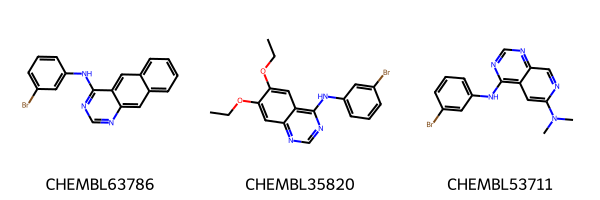

In [56]:
egfr_data = pd.read_csv("data/EGFR_compounds_lipinski.csv",
    index_col=0,
)
# Drop unnecessary information
print("Dataframe shape:", egfr_data.shape)
egfr_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
PandasTools.AddMoleculeColumnToFrame(egfr_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(egfr_data.head(3).ROMol),
    legends=list(egfr_data.head(3).molecule_chembl_id),
)

#### Filter for PAINS

The PAINS filter is already implemented in RDKit (documentation). Such pre-defined filters can be applied via the FilterCatalog class. Let's learn how it can be used.


In [57]:
import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

# search for PAINS
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/4635 [00:00<?, ?it/s]

Number of compounds with PAINS: 408
Number of compounds without PAINS: 4227


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled,ROMol
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,True,
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,True,
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,True,
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,True,
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,True,

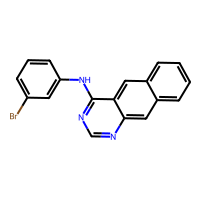
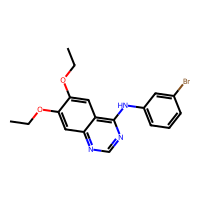
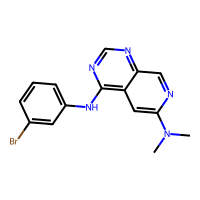
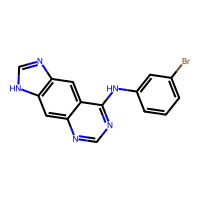
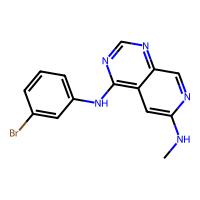

In [59]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(egfr_data)}")
egfr_data.head()


#### Filter and highlight unwanted substructures

Some lists of unwanted substructures, like PAINS, are already implemented in RDKit. However, it is also possible to use an external list and get the substructure matches manually. Here, we use the list provided in the supporting information from Brenk et al. (Chem. Med. Chem. (2008), 3, 535-44).


Number of unwanted substructures in collection: 104


<>:1: DeprecationWarning: invalid escape sequence '\s'
<>:1: DeprecationWarning: invalid escape sequence '\s'
C:\Users\AbhikSeal\AppData\Local\Temp\ipykernel_26408\2566056679.py:1: DeprecationWarning: invalid escape sequence '\s'
  substructures = pd.read_csv("data/unwanted_substructures.csv", sep="\s+")


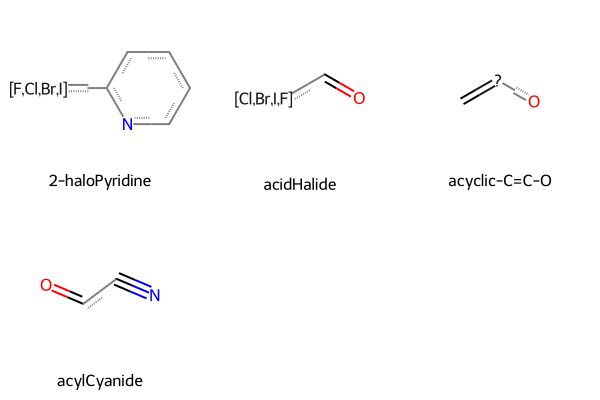

In [61]:
substructures = pd.read_csv("data/unwanted_substructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))

Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[1:5],
    legends=substructures.name.tolist()[1:5],
)

In [62]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]

print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(egfr_data)}")

  0%|          | 0/4227 [00:00<?, ?it/s]

Number of found unwanted substructure: 3232
Number of compounds without unwanted substructure: 2089


In [63]:

#### Substructure statistics

# Finally, we want to find the most frequent substructure found in our data set. The Pandas DataFrame provides convenient methods to group containing data and to retrieve group sizes.

groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
Michael-acceptor               1113
Aliphatic-long-chain            489
Oxygen-nitrogen-single-bond     367
triple-bond                     252
nitro-group                     177
imine                           150
Thiocarbonyl-group              114
aniline                          64
halogenated-ring                 62
conjugated-nitrile-group         59
dtype: int64

#### Generate Molecular Descriptors 

In [65]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
import pandas as pd

# Step 1: Read the CSV file
egfr_data = pd.read_csv("data/EGFR_compounds_lipinski.csv",
    index_col=0,
)

# Step 2: Convert SMILES to RDKit molecules
egfr_data['Molecule'] = egfr_data['smiles'].apply(Chem.MolFromSmiles)

# Step 3: Compute molecular descriptors
descriptor_calculator = MoleculeDescriptors.MolecularDescriptorCalculator(
    [desc_name for desc_name, _ in Chem.Descriptors.descList]
)
descriptor_names = descriptor_calculator.GetDescriptorNames()

# Compute descriptors for each molecule
descriptors = egfr_data['Molecule'].apply(descriptor_calculator.CalcDescriptors)

# Convert descriptors to a DataFrame
descriptors_df = pd.DataFrame(descriptors.tolist(), columns=descriptor_names)

# Step 4: Combine with the original DataFrame and save to a new CSV file
output_df = pd.concat([egfr_data, descriptors_df], axis=1)
# output_csv = 'molecular_descriptors.csv'
# output_df.to_csv(output_csv, index=False)
output_df.head()
#print(f"Molecular descriptors computed and saved to {output_csv}")

[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerator
[12:21:29] DEPRECATION WARNING: please use MorganGenerat

,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled,...,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,349.021459,3.0,1.0,5.2891,True,...,3.0,1.0,4.0,2.0,0.0,0.0,0.0,4.0,5.2891,94.4687
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,387.058239,5.0,1.0,4.9333,True,...,5.0,1.0,6.0,6.0,0.0,0.0,0.0,3.0,4.9333,99.3007
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,343.043258,5.0,1.0,3.5969,True,...,5.0,1.0,6.0,3.0,0.0,0.0,0.0,3.0,3.5969,89.0847
3,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,339.011957,4.0,2.0,4.0122,True,...,4.0,2.0,6.0,2.0,0.0,0.0,0.0,4.0,4.0122,86.6144
4,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,329.027607,5.0,2.0,3.5726,True,...,5.0,2.0,6.0,3.0,0.0,0.0,0.0,3.0,3.5726,84.3044
